<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/EDA_noAMPL_InstructorCopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. Add the Columbia_E4511 folder to your google drive
3. For homework, you will work on this entire notebook for your own targets. Download them here:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Mount your drive where you have the Columbia_E4511 folder

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install packages

In [9]:
! pip install molvs

In [10]:
# thanks to https://web.navan.dev/posts/2020-07-01-Install-rdkit-colab/
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

rdkit is already installed
rdkit is already installed


In [11]:
sys.path.append('/content/drive/MyDrive/Columbia_E4511/AMPL_EDA')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/root/miniconda/lib/python3.7/site-packages',
 '/content/drive/MyDrive/Columbia_E4511/AMPL_EDA',
 '/content/drive/MyDrive/Columbia_E4511/AMPL_EDA']

## Load packages

In [12]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
import struct_utils
import curate_data
import dist_metrics

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

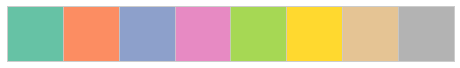

In [13]:
sns.palplot(pal)

## Load data

In [14]:
chembl = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL.csv")
dtc = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC.csv")
excape = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape.csv")

In [15]:
!wget https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/DTC_CYP2C9.csv

--2021-03-11 23:23:53--  https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/DTC_CYP2C9.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9930992 (9.5M) [text/plain]
Saving to: ‘DTC_CYP2C9.csv’

DTC_CYP2C9.csv      100%[===================>]   9.47M  38.9MB/s    in 0.2s    

2021-03-11 23:23:53 (38.9 MB/s) - ‘DTC_CYP2C9.csv’ saved [9930992/9930992]



# Examine data
- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

In [25]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces in column names
print(chembl.shape)

(1950, 45)


In [26]:
chembl.head()

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0      CHEMBL3233676           NaN                   0           622.85   
1          CHEMBL773       GLYCINE                   4            75.07   
2      CHEMBL3261486           NaN                   0           312.37   
3      CHEMBL3943065           NaN                   0           401.47   
4      CHEMBL2086584           NaN                   0           427.55   

  #RO5_Violations  AlogP Compound_Key  \
0               2   6.84          22a   
1               0  -0.97      glycine   
2               0   0.88            9   
3               0   2.21   BDBM221658   
4               0   2.99           27   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   
3   CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2          IC50   
4  COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   
3               '='            1.81             nM           8.74   
4               '>'        30000.00             nM            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   
3                   NaN          388070  UO_0000065                  21.78   
4                   NaN             NaN  UO_0000065                    NaN   

  Ligand_Efficiency_LE Ligand_Efficiency_LLE Ligand_Efficiency_SEI  \
0                  NaN                   NaN                   NaN   
1                  NaN                   NaN                   NaN   
2                  NaN                   NaN                   NaN   
3                 0.43                  6.53                  12.1   
4                  NaN                   NaN                   NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   
3                False   CHEMBL3888296   
4                False   CHEMBL2091623   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   
3  In Vitro Inhibition of Ca Flux Assay: The 5HT3...          B   BAO_0000219   
4  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                   None              None   
1  cell-based format   Homo sapiens                   None              None   
2  cell-based format   Homo sapiens                   None              None   
3  cell-based format   Homo sapiens                   None              None   
4  cell-based format   Homo sapiens                   None              None   

  Assay_Cell_Type Assay_Subcellular_Fraction Assay_Parameters  \
0            None                       None              NaN   
1          HEK293                       None              NaN   
2          HEK293                       None              NaN   
3        HEK-293T                       None              NaN   
4          HEK293               

In [ ]:
chembl.Standard_Type.value_counts()

Ki                                                     611
IC50                                                   558
Inhibition                                             478
Activity                                               138
Ka                                                      46
EC50                                                    41
Vmax                                                    25
Kd                                                      22
% Inhibition of Control Specific Binding (Mean n=2)      8
% Ctrl                                                   8
Efficacy                                                 4
pKi                                                      4
pIC50                                                    3
Emax                                                     2
Selectivity ratio                                        1
Kb                                                       1
Name: Standard_Type, dtype: int64

## Exercise: Explore datasets
- load dtc and excape datasets with pandas
- explore the dataframes
- answer questions below

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

What other information might be useful?

#### ..

In [17]:
dtc = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC.csv")
dtc.columns = dtc.columns.str.replace(' ','_')
print(dtc.shape)

(1310, 43)


In [18]:
dtc.head()

Compound_ID Uniprot_ID  Compound_Name           Standard_inchi_key  \
0   CHEMBL100086     P46098            NaN  OSVMSQACZRYAPT-UHFFFAOYSA-N   
1   CHEMBL104700     P46098            NaN  SCDKHPSUXHBJDJ-UHFFFAOYSA-N   
2  CHEMBL1079079     P46098            NaN  WGIPGQAPFNVWIX-XXFZXMJFSA-N   
3      CHEMBL108     P46098  CARBAMAZEPINE  FFGPTBGBLSHEPO-UHFFFAOYSA-N   
4  CHEMBL1082723     P46098        NITD609  CKLPLPZSUQEDRT-WPCRTTGESA-N   

   Max_Phase                Target_Pref_Name Gene_Names Target_Class  \
0          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
1          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
2          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
3          4  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
4          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   

   Wild_type_or_mutant  Mutation_information   PubMed_ID  \
0                  NaN                   NaN  12482441.0   
1                  NaN                   NaN  22607684.0   
2                  NaN                   NaN  19767206.0   
3                  NaN                   NaN  19144451.0   
4                  NaN                   NaN  20813948.0   

  End_Point_Standard_Type End_Point_Standard_Relation  \
0                    IC50                           >   
1                      KI                         NaN   
2              INHIBITION                           <   
3              INHIBITION                          <=   
4                    IC50                           >   

   End_Point_Standard_Value End_Point_Standard_Units  Endpoint_Mode_of_Action  \
0                  100000.0                       NM                      NaN   
1                       NaN                      NaN                      NaN   
2                      50.0                        %                      NaN   
3                      50.0                        %                      NaN   
4                   10000.0                       NM                      NaN   

  Assay_Format  Assay_Type  Assay_Sub_Type  Inhibitor_Type  \
0          NaN         NaN             NaN             NaN   
1          NaN         NaN             NaN             NaN   
2          NaN         NaN             NaN             NaN   
3   cell_based         NaN             NaN             NaN   
4          NaN         NaN             NaN             NaN   

   Detection_Technology  Compound_concentration_value  \
0                   NaN                           NaN   
1                   NaN                           NaN   
2                   NaN                           NaN   
3                   NaN                           NaN   
4                   NaN                           NaN   

   Compound_concentration_value_units  Substrate_type  \
0                                 NaN             NaN   
1                                 NaN             NaN   
2                                 NaN             NaN   
3                                 NaN             NaN   
4                                 NaN             NaN   

   Substrate_Type_Standard_Relation  Substrate_Type_Standard_Value  \
0                               NaN                            NaN   
1                               NaN                            NaN   
2                               NaN                            NaN   
3                               NaN                            NaN   
4                               NaN                            NaN   

   Substrate_Type_Standard_Units Assay_cell_line  \
0                            NaN             NaN   
1                            NaN             NaN   
2                            NaN             NaN   
3                            NaN          HEK293   
4                            NaN             NaN   

                                   Assay_Description Activity_Comments  \
0  Inhibitory concentration required against 5-HT...           

In [19]:
dtc['End_Point_Standard_Type'].value_counts()

KI                   627
INHIBITION           258
IC50                 247
ACTIVITY             107
EC50                  28
VMAX                  25
EFFICACY               4
PKI                    4
KD                     4
PIC50                  3
KB                     1
SELECTIVITY RATIO      1
EMAX                   1
Name: End_Point_Standard_Type, dtype: int64

In [20]:
excape = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape.csv")
excape.columns = excape.columns.str.replace(' ','_')
print(excape.shape)

(649, 11)


In [21]:
excape.head()

Ambit_InchiKey Original_Entry_ID  Entrez_ID Activity_Flag  \
0  AZGOVLGMSGAOMP-FZYUQVBKNA-N      CHEMBL404232       3359             A   
1  BAZZAIKMNMNZJS-PKRZOPRNNA-N      CHEMBL494999      79246             A   
2  ARXTZNGJWWBBMH-LQFNOIFHNA-N          44157937      79246             A   
3  ASQVLAWCAVGHRV-UHFFFAOYNA-N      CHEMBL576046      79246             A   
4  ATBPRFXCCZLQCU-KHCWMJRFNA-N       CHEMBL40260       3359             A   

     pXC50        DB  Original_Assay_ID  Tax_ID Gene_Symbol  Ortholog_Group  \
0  5.52000  chembl20             989092    9606       HTR3A            2102   
1  7.36000  chembl20             523350   10116       HTR3A            2102   
2  8.52288   pubchem             375321   10116       HTR3A            2102   
3  7.65000  chembl20             592418   10116       HTR3A            2102   
4  8.48000  chembl20               3470    9606       HTR3A            2102   

                                              SMILES  
0        C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1  
1  N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...  
2   OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C  
3  N1(C=NC=C1)CCN2CCN(C3=NC4=CC(=CC=C4N5C3=CC=C5)...  
4             C1(C=2N=C(CN=C(N)N)SC2)=CNC=3C1=CC=CC3

In [22]:
excape.Activity_Flag.unique()

array(['A', 'N'], dtype=object)

In [23]:
# - log10 of concentration /value in MOLAR units
- np.log10(1.81e-9)

8.742321425130816

other useful info:
- standard relation column
- assay information

In [27]:
len(chembl.Assay_Description.unique()) # maybe not so useful after all

347

# EDA: assay data responses
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [28]:
chembl.head()

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0      CHEMBL3233676           NaN                   0           622.85   
1          CHEMBL773       GLYCINE                   4            75.07   
2      CHEMBL3261486           NaN                   0           312.37   
3      CHEMBL3943065           NaN                   0           401.47   
4      CHEMBL2086584           NaN                   0           427.55   

  #RO5_Violations  AlogP Compound_Key  \
0               2   6.84          22a   
1               0  -0.97      glycine   
2               0   0.88            9   
3               0   2.21   BDBM221658   
4               0   2.99           27   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   
3   CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2          IC50   
4  COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   
3               '='            1.81             nM           8.74   
4               '>'        30000.00             nM            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   
3                   NaN          388070  UO_0000065                  21.78   
4                   NaN             NaN  UO_0000065                    NaN   

  Ligand_Efficiency_LE Ligand_Efficiency_LLE Ligand_Efficiency_SEI  \
0                  NaN                   NaN                   NaN   
1                  NaN                   NaN                   NaN   
2                  NaN                   NaN                   NaN   
3                 0.43                  6.53                  12.1   
4                  NaN                   NaN                   NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   
3                False   CHEMBL3888296   
4                False   CHEMBL2091623   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   
3  In Vitro Inhibition of Ca Flux Assay: The 5HT3...          B   BAO_0000219   
4  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                   None              None   
1  cell-based format   Homo sapiens                   None              None   
2  cell-based format   Homo sapiens                   None              None   
3  cell-based format   Homo sapiens                   None              None   
4  cell-based format   Homo sapiens                   None              None   

  Assay_Cell_Type Assay_Subcellular_Fraction Assay_Parameters  \
0            None                       None              NaN   
1          HEK293                       None              NaN   
2          HEK293                       None              NaN   
3        HEK-293T                       None              NaN   
4          HEK293               

In [29]:
chembl.Standard_Units.unique()

array(['%', nan, 'nM', 'uM'], dtype=object)

## **Curation step**: change units to be the same for all responses

In [31]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [ ]:
# summary statistics
chembl.describe()

Molecule_Max_Phase  Standard_Value  pChEMBL_Value  \
count         1950.000000    1.784000e+03     975.000000   
mean             0.286667    6.279166e+04       7.277262   
std              0.984944    2.367589e+06       1.601719   
min              0.000000   -1.889000e+01       4.000000   
25%              0.000000    3.000000e+00       5.990000   
50%              0.000000    5.000000e+01       7.500000   
75%              0.000000    7.910825e+02       8.700000   
max              4.000000    1.000000e+08      10.500000   

       Ligand_Efficiency_BEI    Source_ID  Document_Year  Standard_Value_nM  
count             810.000000  1950.000000    1801.000000       1.784000e+03  
mean               22.023802     9.757436    2012.493615       6.299437e+04  
std                 6.780721    17.537913       4.327058       2.367584e+06  
min                 4.500000     1.000000    1990.000000      -1.889000e+01  
25%                18.225000     1.000000    2010.000000       3.097500e+00  
50%                23.025000     1.000000    2013.000000       5.000000e+01  
75%                25.970000     1.000000    2016.000000       1.089650e+03  
max                49.740000    54.000000    2020.000000       1.000000e+08

- **Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries**

In [32]:
chembl=chembl.replace('None',np.nan)

In [33]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

In [34]:
chembl.describe()

Molecule_Max_Phase  Molecular_Weight  #RO5_Violations        AlogP  \
count         1950.000000       1949.000000      1941.000000  1941.000000   
mean             0.286667        387.760164         0.224111     3.162499   
std              0.984944        141.507010         0.559598     1.507776   
min              0.000000         75.070000         0.000000    -2.230000   
25%              0.000000        309.330000         0.000000     2.140000   
50%              0.000000        361.450000         0.000000     2.920000   
75%              0.000000        426.470000         0.000000     3.860000   
max              4.000000       1165.320000         3.000000    10.370000   

       Standard_Value  pChEMBL_Value  Ligand_Efficiency_BEI  \
count    1.784000e+03     975.000000             810.000000   
mean     6.279166e+04       7.277262              22.023802   
std      2.367589e+06       1.601719               6.780721   
min     -1.889000e+01       4.000000               4.500000   
25%      3.000000e+00       5.990000              18.225000   
50%      5.000000e+01       7.500000              23.025000   
75%      7.910825e+02       8.700000              25.970000   
max      1.000000e+08      10.500000              49.740000   

       Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
count            807.000000             807.000000             807.000000   
mean               0.420867               4.651921              16.968451   
std                0.128024               2.224646              10.960766   
min                0.080000              -4.390000               2.880000   
25%                0.350000               3.545000              10.820000   
50%                0.440000               4.980000              14.430000   
75%                0.500000               6.385000              19.665000   
max                0.950000               9.330000             106.270000   

       Assay_Subcellular_Fraction    Source_ID  Document_Year  \
count                         0.0  1950.000000    1801.000000   
mean                          NaN     9.757436    2012.493615   
std                           NaN    17.537913       4.327058   
min                           NaN     1.000000    1990.000000   
25%                           NaN     1.000000    2010.000000   
50%                           NaN     1.000000    2013.000000   
75%                           NaN     1.000000    2016.000000   
max                           NaN    54.000000    2020.000000   

       Standard_Value_nM  
count       1.784000e+03  
mean        6.299437e+04  
std         2.367584e+06  
min        -1.889000e+01  
25%         3.097500e+00  
50%         5.000000e+01  
75%         1.089650e+03  
max         1.000000e+08

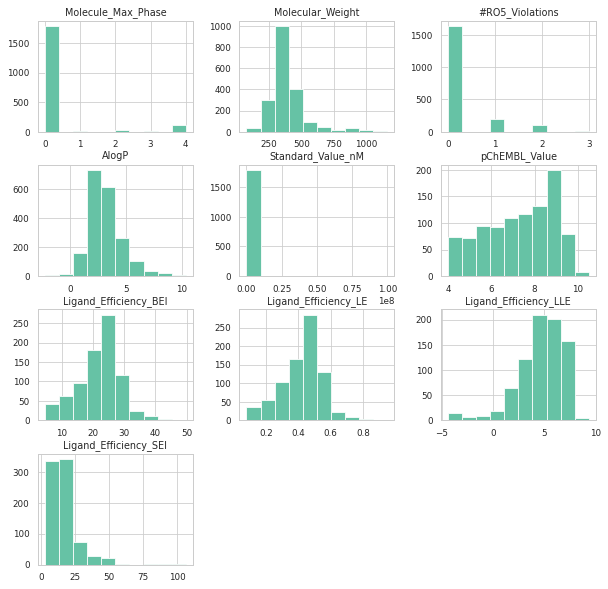

In [35]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types / assays represented in the value columns. Let's split those up:**

Standard_Type      % Ctrl  \
count            7.000000   
mean           109.714286   
std             15.283044   
min             94.000000   
25%             99.000000   
50%            101.000000   
75%            120.500000   
max            134.000000   

Standard_Type  % Inhibition of Control Specific Binding (Mean n=2)  \
count                                                   8.000000     
mean                                                   -3.700000     
std                                                     4.452287     
min                                                   -10.700000     
25%                                                    -6.350000     
50%                                                    -4.350000     
75%                                                     0.350000     
max                                                     2.000000     

Standard_Type      Activity          EC50   Efficacy       Emax  \
count             41.000000     24.000000   4.000000   2.000000   
mean             260.273171   7554.570706  25.225000  54.500000   
std             1559.327343  13061.147535  28.866402  55.861436   
min              -12.900000      1.100000  -0.100000  15.000000   
25%               -0.500000    178.000000   5.225000  34.750000   
50%                2.000000    214.222222  18.500000  54.500000   
75%               30.000000  10000.000000  38.500000  74.250000   
max            10000.000000  50118.720000  64.000000  94.000000   

Standard_Type           IC50  Inhibition            Ka   Kb            Kd  \
count             498.000000  418.000000     23.000000  1.0      4.000000   
mean            10069.385426   28.305755   7869.565217  0.3   3270.980750   
std             27059.164344   26.899361   2937.289224  NaN   6486.129538   
min                 0.090000  -18.890000   2200.000000  0.3      0.416000   
25%                 1.720000    4.062500   5350.000000  0.3      0.484250   
50%                80.350000   25.150000  10000.000000  0.3     41.753500   
75%              5451.162500   50.000000  10000.000000  0.3   3312.250000   
max            257039.580000  100.000000  10000.000000  0.3  13000.000000   

Standard_Type            Ki        Vmax  
count          5.020000e+02   25.000000  
mean           2.076276e+05   94.480000  
std            4.463049e+06   17.535084  
min            0.000000e+00   34.500000  
25%            7.300000e+00   96.000000  
50%            1.654800e+02  100.200000  
75%            4.934302e+03  104.000000  
max            1.000000e+08  107.900000

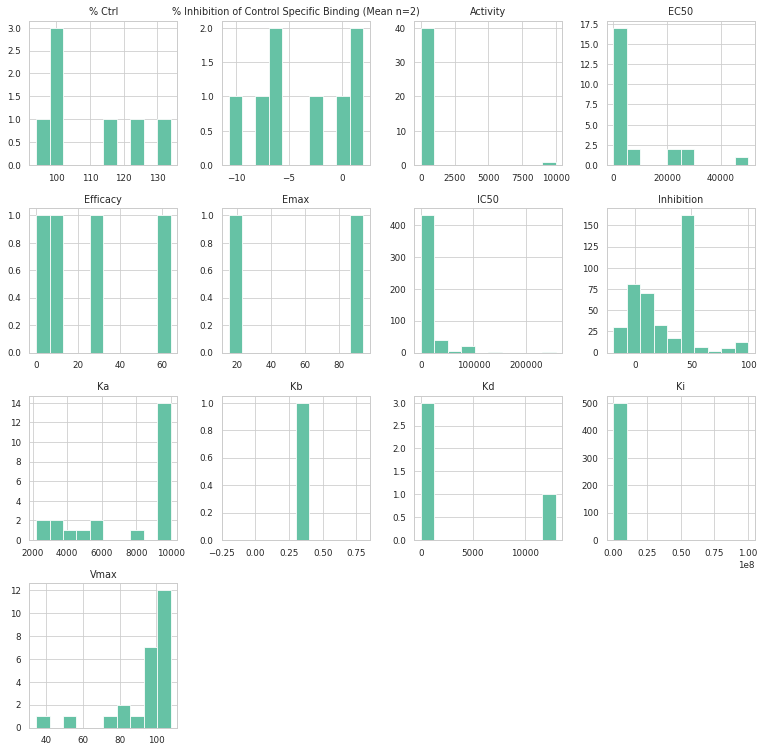

In [36]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

- **What do you notice about the standard values?**

Standard_Type       EC50        IC50        Kd          Ki
count          19.000000  408.000000  4.000000  405.000000
mean            6.684474    7.357423  7.681750    7.178580
std             1.152117    1.676965  2.153942    1.435567
min             4.580000    4.000000  4.890000    4.000000
25%             6.120000    5.792500  6.532500    6.150000
50%             6.750000    7.755000  8.205500    7.285000
75%             7.210000    8.900000  9.354750    8.330000
max             8.960000   10.050000  9.426000   10.500000

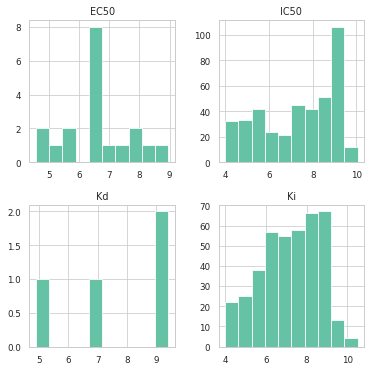

In [37]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way

#### ..

In [38]:
dtc=dtc.replace('None', np.nan)
dtc.head()

Compound_ID Uniprot_ID  Compound_Name           Standard_inchi_key  \
0   CHEMBL100086     P46098            NaN  OSVMSQACZRYAPT-UHFFFAOYSA-N   
1   CHEMBL104700     P46098            NaN  SCDKHPSUXHBJDJ-UHFFFAOYSA-N   
2  CHEMBL1079079     P46098            NaN  WGIPGQAPFNVWIX-XXFZXMJFSA-N   
3      CHEMBL108     P46098  CARBAMAZEPINE  FFGPTBGBLSHEPO-UHFFFAOYSA-N   
4  CHEMBL1082723     P46098        NITD609  CKLPLPZSUQEDRT-WPCRTTGESA-N   

   Max_Phase                Target_Pref_Name Gene_Names Target_Class  \
0          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
1          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
2          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
3          4  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
4          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   

   Wild_type_or_mutant  Mutation_information   PubMed_ID  \
0                  NaN                   NaN  12482441.0   
1                  NaN                   NaN  22607684.0   
2                  NaN                   NaN  19767206.0   
3                  NaN                   NaN  19144451.0   
4                  NaN                   NaN  20813948.0   

  End_Point_Standard_Type End_Point_Standard_Relation  \
0                    IC50                           >   
1                      KI                         NaN   
2              INHIBITION                           <   
3              INHIBITION                          <=   
4                    IC50                           >   

   End_Point_Standard_Value End_Point_Standard_Units  Endpoint_Mode_of_Action  \
0                  100000.0                       NM                      NaN   
1                       NaN                      NaN                      NaN   
2                      50.0                        %                      NaN   
3                      50.0                        %                      NaN   
4                   10000.0                       NM                      NaN   

  Assay_Format  Assay_Type  Assay_Sub_Type  Inhibitor_Type  \
0          NaN         NaN             NaN             NaN   
1          NaN         NaN             NaN             NaN   
2          NaN         NaN             NaN             NaN   
3   cell_based         NaN             NaN             NaN   
4          NaN         NaN             NaN             NaN   

   Detection_Technology  Compound_concentration_value  \
0                   NaN                           NaN   
1                   NaN                           NaN   
2                   NaN                           NaN   
3                   NaN                           NaN   
4                   NaN                           NaN   

   Compound_concentration_value_units  Substrate_type  \
0                                 NaN             NaN   
1                                 NaN             NaN   
2                                 NaN             NaN   
3                                 NaN             NaN   
4                                 NaN             NaN   

   Substrate_Type_Standard_Relation  Substrate_Type_Standard_Value  \
0                               NaN                            NaN   
1                               NaN                            NaN   
2                               NaN                            NaN   
3                               NaN                            NaN   
4                               NaN                            NaN   

   Substrate_Type_Standard_Units Assay_cell_line  \
0                            NaN             NaN   
1                            NaN             NaN   
2                            NaN             NaN   
3                            NaN          HEK293   
4                            NaN             NaN   

                                   Assay_Description Activity_Comments  \
0  Inhibitory concentration required against 5-HT...           

In [39]:
dtc.End_Point_Standard_Units.unique() #already all nM

array(['NM', nan, '%'], dtype=object)

In [40]:
dtc.End_Point_Standard_Type.unique()

array(['IC50', 'KI', 'INHIBITION', 'ACTIVITY', 'EC50', 'KD', 'EMAX',
       'PKI', 'KB', 'VMAX', 'EFFICACY', 'PIC50', 'SELECTIVITY RATIO'],
      dtype=object)

In [41]:
dtc[dtc.End_Point_Standard_Units=='NM'].End_Point_Standard_Type.unique()

array(['IC50', 'KI', 'EC50', 'KD', 'ACTIVITY', 'KB'], dtype=object)

##### **Curation step:** create pValues from normal values

In [49]:
# add pX column
dtc['pDTC_Value'] = np.where(dtc.End_Point_Standard_Units == 'NM',
                             -np.log10(dtc.End_Point_Standard_Value/1000000000 ),
                             dtc.End_Point_Standard_Value)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
dtc.describe()

Max_Phase  Wild_type_or_mutant  Mutation_information     PubMed_ID  \
count  1310.000000                  0.0                   0.0  1.221000e+03   
mean      0.273282                  NaN                   NaN  2.021775e+07   
std       0.959917                  NaN                   NaN  4.378655e+06   
min       0.000000                  NaN                   NaN  1.652026e+06   
25%       0.000000                  NaN                   NaN  1.920847e+07   
50%       0.000000                  NaN                   NaN  2.114699e+07   
75%       0.000000                  NaN                   NaN  2.295924e+07   
max       4.000000                  NaN                   NaN  2.813524e+07   

       End_Point_Standard_Value  Endpoint_Mode_of_Action  Assay_Type  \
count              1.184000e+03                      0.0         0.0   
mean               9.446193e+04                      NaN         NaN   
std                2.906114e+06                      NaN         NaN   
min               -1.700000e+01                      NaN         NaN   
25%                1.336750e+01                      NaN         NaN   
50%                7.580000e+01                      NaN         NaN   
75%                3.750000e+03                      NaN         NaN   
max                1.000000e+08                      NaN         NaN   

       Assay_Sub_Type  Inhibitor_Type  Detection_Technology  \
count             0.0             0.0                   0.0   
mean              NaN             NaN                   NaN   
std               NaN             NaN                   NaN   
min               NaN             NaN                   NaN   
25%               NaN             NaN                   NaN   
50%               NaN             NaN                   NaN   
75%               NaN             NaN                   NaN   
max               NaN             NaN                   NaN   

       Compound_concentration_value  Compound_concentration_value_units  \
count                           0.0                                 0.0   
mean                            NaN                                 NaN   
std                             NaN                                 NaN   
min                             NaN                                 NaN   
25%                             NaN                                 NaN   
50%                             NaN                                 NaN   
75%                             NaN                                 NaN   
max                             NaN                                 NaN   

       Substrate_type  Substrate_Type_Standard_Relation  \
count             0.0                               0.0   
mean              NaN                               NaN   
std               NaN                               NaN   
min               NaN                               NaN   
25%               NaN                               NaN   
50%               NaN                               NaN   
75%               NaN                               NaN   
max               NaN                               NaN   

       Substrate_Type_Standard_Value  Substrate_Type_Standard_Units  \
count                            0.0                            0.0   
mean                             NaN                            NaN   
std                              NaN                            NaN   
min                              NaN                            NaN   
25%                              NaN                            NaN   
50%                              NaN                            NaN   
75%                              NaN                            NaN   
max                              NaN                            NaN   

              Year       Volume        Issue  Annotation_Comments  \
count  1191.000000  1129.000000  1099.000000                  0.0   
mean   2010.376154    40.450841    64.520473                  NaN   
std       3.739353    38.

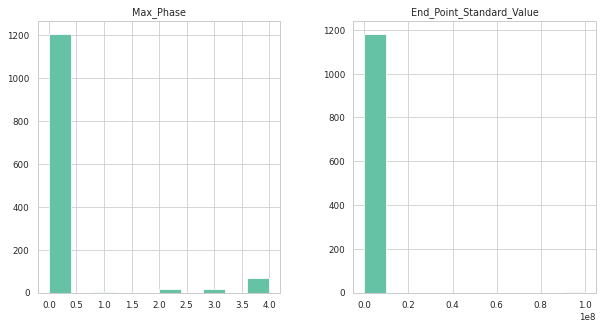

In [44]:
numeric_cols=['Max_Phase', 'End_Point_Standard_Value']
dtc[numeric_cols].hist(figsize=(10,5));

End_Point_Standard_Type      ACTIVITY          EC50   EFFICACY  EMAX  \
count                       26.000000     19.000000   4.000000   1.0   
mean                       411.119231   4869.599605  25.225000  15.0   
std                       1955.960159  12577.519415  28.866402   NaN   
min                         -7.000000      1.100000  -0.100000  15.0   
25%                         -0.250000    101.000000   5.225000  15.0   
50%                         28.000000    178.000000  18.500000  15.0   
75%                         50.000000   1210.000000  38.500000  15.0   
max                      10000.000000  50118.720000  64.000000  15.0   

End_Point_Standard_Type           IC50  INHIBITION   KB            KD  \
count                       194.000000  232.000000  1.0      4.000000   
mean                      18830.922569   34.748922  0.3   3270.962500   
std                       34557.858497   26.254918  NaN   6486.141808   
min                           0.090000  -17.000000  0.3      0.320000   
25%                         100.000000   10.300000  0.3      0.477500   
50%                        2602.972500   50.000000  0.3     41.765000   
75%                       30000.000000   50.000000  0.3   3312.250000   
max                      251188.640000  100.000000  0.3  13000.000000   

End_Point_Standard_Type            KI        VMAX  
count                    4.900000e+02   25.000000  
mean                     2.126429e+05   94.480000  
std                      4.517362e+06   17.535084  
min                      3.160000e-02   34.500000  
25%                      7.522500e+00   96.000000  
50%                      1.945000e+02  100.200000  
75%                      4.421250e+03  104.000000  
max                      1.000000e+08  107.900000

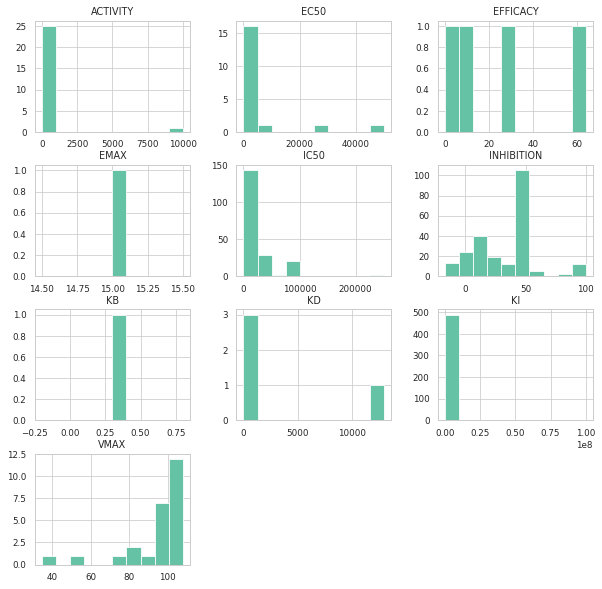

In [45]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='End_Point_Standard_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(10,10));

End_Point_Standard_Type   ACTIVITY       EC50   EFFICACY  EMAX        IC50  \
count                    26.000000  19.000000   4.000000   1.0  194.000000   
mean                     26.696154   6.630151  25.225000  15.0    5.787025   
std                      28.630997   1.211224  28.866402   NaN    1.295001   
min                      -7.000000   4.300000  -0.100000  15.0    3.600000   
25%                      -0.250000   6.086315   5.225000  15.0    4.522879   
50%                      23.500000   6.749580  18.500000  15.0    5.601545   
75%                      50.000000   7.184684  38.500000  15.0    7.000000   
max                      87.000000   8.958607  64.000000  15.0   10.045757   

End_Point_Standard_Type  INHIBITION        KB        KD          KI  \
count                    232.000000  1.000000  4.000000  490.000000   
mean                      34.748922  9.522879  7.684388    6.788864   
std                       26.254918       NaN  2.160629    1.555564   
min                      -17.000000  9.522879  4.886057    1.000000   
25%                       10.300000  9.522879  6.532206    5.402234   
50%                       50.000000  9.522879  8.178323    6.811128   
75%                       50.000000  9.522879  9.330506    8.136677   
max                      100.000000  9.522879  9.494850   10.500313   

End_Point_Standard_Type        VMAX  
count                     25.000000  
mean                      94.480000  
std                       17.535084  
min                       34.500000  
25%                       96.000000  
50%                      100.200000  
75%                      104.000000  
max                      107.900000

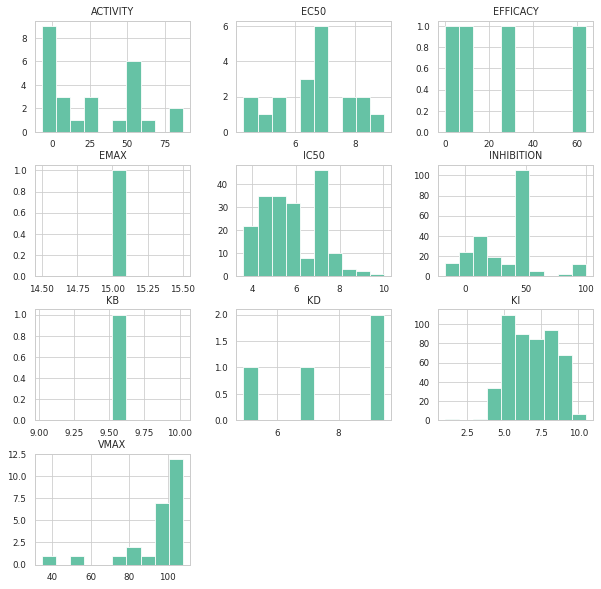

In [46]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='pDTC_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(10,10));

In [47]:
excape=excape.replace('None', np.nan)
excape.head()

Ambit_InchiKey Original_Entry_ID  Entrez_ID Activity_Flag  \
0  AZGOVLGMSGAOMP-FZYUQVBKNA-N      CHEMBL404232       3359             A   
1  BAZZAIKMNMNZJS-PKRZOPRNNA-N      CHEMBL494999      79246             A   
2  ARXTZNGJWWBBMH-LQFNOIFHNA-N          44157937      79246             A   
3  ASQVLAWCAVGHRV-UHFFFAOYNA-N      CHEMBL576046      79246             A   
4  ATBPRFXCCZLQCU-KHCWMJRFNA-N       CHEMBL40260       3359             A   

     pXC50        DB  Original_Assay_ID  Tax_ID Gene_Symbol  Ortholog_Group  \
0  5.52000  chembl20             989092    9606       HTR3A            2102   
1  7.36000  chembl20             523350   10116       HTR3A            2102   
2  8.52288   pubchem             375321   10116       HTR3A            2102   
3  7.65000  chembl20             592418   10116       HTR3A            2102   
4  8.48000  chembl20               3470    9606       HTR3A            2102   

                                              SMILES  
0        C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1  
1  N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...  
2   OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C  
3  N1(C=NC=C1)CCN2CCN(C3=NC4=CC(=CC=C4N5C3=CC=C5)...  
4             C1(C=2N=C(CN=C(N)N)SC2)=CNC=3C1=CC=CC3

Entrez_ID       pXC50  Original_Assay_ID        Tax_ID  \
count    649.000000  645.000000       6.490000e+02    649.000000   
mean   16215.274268    6.983770       6.633640e+05   9715.318952   
std    27698.741204    1.505524       2.569910e+05    207.728422   
min     3359.000000    1.000000       3.123000e+03   9606.000000   
25%     3359.000000    5.800000       5.369680e+05   9606.000000   
50%     3359.000000    7.161150       6.525690e+05   9606.000000   
75%     3359.000000    8.140000       8.059070e+05   9606.000000   
max    79246.000000   10.500000       1.350972e+06  10116.000000   

       Ortholog_Group  
count           649.0  
mean           2102.0  
std               0.0  
min            2102.0  
25%            2102.0  
50%            2102.0  
75%            2102.0  
max            2102.0

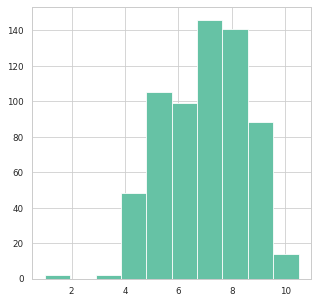

In [48]:
# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));

## Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

#### ..

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

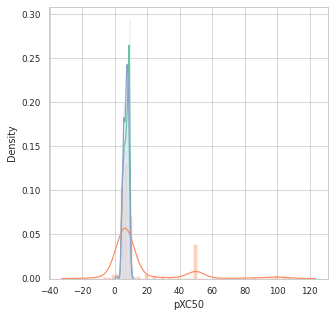

In [51]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)
sns.distplot(dtc.pDTC_Value, ax=ax)
sns.distplot(excape.pXC50, ax=ax);

In [52]:
chembl.head()

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
0      CHEMBL3233676           NaN                 0.0            622.85   
1          CHEMBL773       GLYCINE                 4.0             75.07   
2      CHEMBL3261486           NaN                 0.0            312.37   
3      CHEMBL3943065           NaN                 0.0            401.47   
4      CHEMBL2086584           NaN                 0.0            427.55   

   #RO5_Violations  AlogP Compound_Key  \
0              2.0   6.84          22a   
1              0.0  -0.97      glycine   
2              0.0   0.88            9   
3              0.0   2.21   BDBM221658   
4              0.0   2.99           27   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   
3   CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2          IC50   
4  COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   
3               '='            1.81             nM           8.74   
4               '>'        30000.00             nM            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   
3                   NaN          388070  UO_0000065                  21.78   
4                   NaN             NaN  UO_0000065                    NaN   

   Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                  0.43                   6.53                   12.1   
4                   NaN                    NaN                    NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   
3                False   CHEMBL3888296   
4                False   CHEMBL2091623   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   
3  In Vitro Inhibition of Ca Flux Assay: The 5HT3...          B   BAO_0000219   
4  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                    NaN               NaN   
1  cell-based format   Homo sapiens                    NaN               NaN   
2  cell-based format   Homo sapiens                    NaN               NaN   
3  cell-based format   Homo sapiens                    NaN               NaN   
4  cell-based format   Homo sapiens                    NaN               NaN   

  Assay_Cell_Type  Assay_Subcellular_Fraction Assay_Parameters  \
0             NaN                         NaN              NaN   
1          HEK293                         NaN              NaN   
2          HEK293                         NaN              NaN   
3        HEK-293T                         NaN              NaN 

## Exercise: analysis
- what value types you would model and why?
- how would you use this data for a classification model?

#### ..

- I would model either pXC50 or pKI values. They are the most abundant in the dataset and commonly used for modeling. pKI is more normally distributed, but pXC50 values allow inclusion of excape data. 

According to some sources, these two datapoints can be combined in various ways, as well, but that's beyond the scope of this class.

- I would choose a reasonable IC50 concentration to use as a threshold (perhaps 10uM, or consult with a scientist), and anything with an IC50 above that threshold is inactive (you need more drug to get activity) and IC50s below this threshold is active (you need less drug for activity, meaning the compound is MORE active per unit)

# EDA: Compounds

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi
  3. Be sure to select the correct registry ID for the input id list
  4. Select "Same CID" and SMILES as output
5. upload resulting text file into Columbia_E4511 folder

In [53]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/4126088262339275864.txt", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

ChEMBL_ID                                             SMILES
0   CHEMBL100086  COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...
1   CHEMBL104700                            C1CC2CCC1N2CC3=CN=CC=C3
2  CHEMBL1079079  COC1=CC=C(C=C1)C2=C(C(=NN2C3=CC=CC=C3[125I])C(...
3      CHEMBL108               C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N
4  CHEMBL1082723  C[C@H]1CC2=C([C@]3(N1)C4=C(C=CC(=C4)Cl)NC3=O)N...

In [54]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['Compound_ID'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [55]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['Compound_ID'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 29
No SMILES from ChemblID in DTC: 33


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [ ]:
# try it yourself here

#### ..

In [ ]:
dtc[dtc.SMILES.isna()]['Standard_inchi_key'].unique().tolist()

['BXTUHNWXQLWICJ-DIXMSKSGSA-L',
 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
 'VBOQYPQEPHKASR-GSVOUGTGSA-N',
 'PDNJLMZEGXHSCU-GSVOUGTGSA-N',
 'KIWQWJKWBHZMDT-GSVOUGTGSA-N',
 'VBOQYPQEPHKASR-UHFFFAOYSA-N',
 'DYIRSNMPIZZNBK-UHFFFAOYSA-N',
 'HXTGXYRHXAGCFP-UHFFFAOYSA-N',
 'WPEBMRNXFWCMHU-UHFFFAOYSA-N',
 'ZITSATWAZDKOBF-UHFFFAOYSA-N',
 'KRBFLOBPUMORJO-UHFFFAOYSA-N',
 'IDRHDKGNUNKODU-UHFFFAOYSA-N',
 'IVHTZIIPDCREHO-UHFFFAOYSA-N',
 'WPPPKVSENOHDIG-UHFFFAOYSA-N',
 'BWGIECJEQVGDRP-UHFFFAOYSA-N',
 'PKNNCDGLZOSLJS-UHFFFAOYSA-N',
 'SUGVYNSRNKFXQM-ACSDJOOWSA-N',
 'QLOOWOVVZLBYHU-UHFFFAOYSA-N',
 'YPAKIZUIDJVWEU-UHFFFAOYSA-N',
 'IULBXDZWXBXGNP-UHFFFAOYSA-N',
 'JBGBKQZMARTYMJ-UHFFFAOYSA-N',
 'OIOMPFBFUIBOFU-UHFFFAOYSA-N',
 'YQZJKNSLWYSIQK-UHFFFAOYSA-N',
 'GKQNHLVTVYRVPU-UHFFFAOYSA-N',
 'FHGYGOURWHLFKB-UHFFFAOYSA-N',
 'BYOFGWKOPRCCDL-UHFFFAOYSA-N',
 'BKOSOHWFMPLYRS-UHFFFAOYSA-N',
 'HOASDGCNODVMOU-UHFFFAOYSA-N']

In [ ]:
inchi_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/1796034019331771858.txt", sep='\t', header=None)
inchi_smiles=inchi_smiles.rename(columns = {0:'INCHIKEY',1:'SMILES'})
inchi_smiles

INCHIKEY
0  Result set is empty.

Pubchem doesn't ID any of these INCHI Keys. Depending on how precious your data is and how many data points are missing, it may be worth going to other sources manually, such as chemspider: http://www.chemspider.com/Search.aspx?q=InChIKey=BXTUHNWXQLWICJ-DIXMSKSGSA-L

## EDA: Explore compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

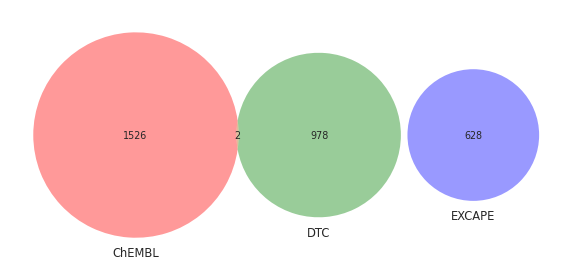

In [ ]:
# overlaps from SMILES strings
mpv.venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

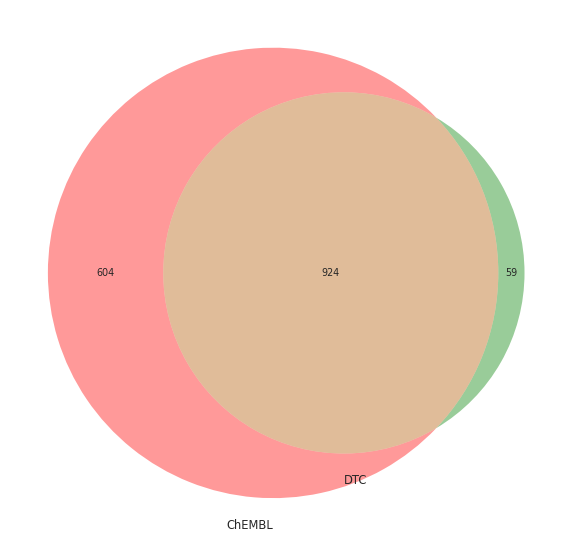

In [ ]:
# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists
mpv.venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.Compound_ID)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without

In [ ]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(struct_utils.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

1950
1528
1528


In [ ]:
chembl[chembl.base_rdkit_smiles=='']

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
1638      CHEMBL4532510           NaN                 0.0               NaN   

      #RO5_Violations  AlogP Compound_Key Smiles Standard_Type  \
1638              NaN    NaN          NaN    NaN    Inhibition   

     Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
1638               '='            4.05              %            NaN   

     Data_Validity_Comment     Comment    Uo_Units  Ligand_Efficiency_BEI  \
1638                   NaN  Not Active  UO_0000187                    NaN   

      Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
1638                   NaN                    NaN                    NaN   

      Potential_Duplicate Assay_ChEMBL_ID  \
1638                False   CHEMBL4507808   

                        Assay_Description Assay_Type BAO_Format_ID  \
1638  GPCRScan assay: inhibition of 5-HT3          B   BAO_0000357   

                  BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
1638  single protein format   Homo sapiens                    NaN   

     Assay_Tissue_Name Assay_Cell_Type  Assay_Subcellular_Fraction  \
1638               NaN             NaN                         NaN   

                                       Assay_Parameters  \
1638  Parental cells: HEKT | PMID: 2164935/8436978 |...   

     Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
1638                     NaN                    NaN       CHEMBL1899   

                         Target_Name Target_Organism     Target_Type  \
1638  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

     Document_ChEMBL_ID  Source_ID                       Source_Description  \
1638      CHEMBL4507304         54  Donated Chemical Probes - SGC Frankfurt   

     Document_Journal  Document_Year Cell_ChEMBL_ID  \
1638              NaN            NaN            NaN   

                               Properties  Standard_Value_nM base_rdkit_smiles  
1638  Compound concentration None 10.0 uM               4.05

In [ ]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
1638      CHEMBL4532510           NaN                 0.0               NaN   

      #RO5_Violations  AlogP Compound_Key Smiles Standard_Type  \
1638              NaN    NaN          NaN    NaN    Inhibition   

     Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
1638               '='            4.05              %            NaN   

     Data_Validity_Comment     Comment    Uo_Units  Ligand_Efficiency_BEI  \
1638                   NaN  Not Active  UO_0000187                    NaN   

      Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
1638                   NaN                    NaN                    NaN   

      Potential_Duplicate Assay_ChEMBL_ID  \
1638                False   CHEMBL4507808   

                        Assay_Description Assay_Type BAO_Format_ID  \
1638  GPCRScan assay: inhibition of 5-HT3          B   BAO_0000357   

                  BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
1638  single protein format   Homo sapiens                    NaN   

     Assay_Tissue_Name Assay_Cell_Type  Assay_Subcellular_Fraction  \
1638               NaN             NaN                         NaN   

                                       Assay_Parameters  \
1638  Parental cells: HEKT | PMID: 2164935/8436978 |...   

     Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
1638                     NaN                    NaN       CHEMBL1899   

                         Target_Name Target_Organism     Target_Type  \
1638  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

     Document_ChEMBL_ID  Source_ID                       Source_Description  \
1638      CHEMBL4507304         54  Donated Chemical Probes - SGC Frankfurt   

     Document_Journal  Document_Year Cell_ChEMBL_ID  \
1638              NaN            NaN            NaN   

                               Properties  Standard_Value_nM base_rdkit_smiles  
1638  Compound concentration None 10.0 uM               4.05               NaN

In [ ]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

#### ..

In [ ]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(struct_utils.base_smiles_from_smiles)
excape['base_rdkit_smiles'] = excape.SMILES.apply(struct_utils.base_smiles_from_smiles)

In [ ]:
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

print(len(excape.SMILES.unique()))
print(len(excape.base_rdkit_smiles.unique()))

980
980
628
605


In [ ]:
# drop na smiles
dtc=dtc.replace('',np.nan) # it's always better to have nan's than empty strings for downstream processing
dtc=dtc[~dtc.base_rdkit_smiles.isna()]

In [ ]:
excape = excape.replace('',np.nan)
excape = excape[~excape.base_rdkit_smiles.isna()]

In [ ]:
# examine which smiles became the same base smiles
excape[excape.base_rdkit_smiles.duplicated(keep=False)].sort_values('base_rdkit_smiles')#.to_csv("excape_dupes.csv")

Ambit_InchiKey Original_Entry_ID  Entrez_ID Activity_Flag  \
384  MJSSERWIBBMXQD-UHFFFAOYNA-N      CHEMBL611369       3359             A   
383  MJSSERWIBBMXQD-UHFFFAOYNA-N          11220991      15561             A   
485  SRWDXYXZNVIWLX-QGZVFWFLNA-N     CHEMBL1958322       3359             A   
484  SRWDXYXZNVIWLX-QGZVFWFLNA-N          56946196      79246             A   
407  QZUDBNBUXVUHMW-UHFFFAOYNA-N              2818      15561             A   
..                           ...               ...        ...           ...   
570  XRXDAJYKGWNHTQ-UHFFFAOYNA-N              5011       3359             A   
50   CXJLWJAYGMWLRR-UHFFFAOYNA-N      CHEMBL611082      15561             A   
51   CXJLWJAYGMWLRR-UHFFFAOYNA-N      CHEMBL611082       3359             A   
165  HIWIXUJADKOVEP-UHFFFAOYNA-N      CHEMBL597843      15561             A   
166  HIWIXUJADKOVEP-UHFFFAOYNA-N      CHEMBL597843       3359             A   

       pXC50        DB  Original_Assay_ID  Tax_ID Gene_Symbol  Ortholog_Group  \
384  6.11000  chembl20             611801    9606       HTR3A            2102   
383  6.03339   pubchem             460741   10090       HTR3A            2102   
485  8.57000  chembl20             805903    9606       HTR3A            2102   
484  8.15490   pubchem             648454   10116       HTR3A            2102   
407  7.49485   pubchem               6022   10090       HTR3A            2102   
..       ...       ...                ...     ...         ...             ...   
570  8.43180   pubchem             297966    9606       HTR3A            2102   
50   7.89000  chembl20             611799   10090       HTR3A            2102   
51   7.89000  chembl20             851152    9606       HTR3A            2102   
165  6.24000  chembl20             611799   10090       HTR3A            2102   
166  6.24000  chembl20             851152    9606       HTR3A            2102   

                                                SMILES  \
384             C12CCN(CCN1C3=NC4=C(O3)C=C(C=N4)Br)CC2   
383               BrC1=CC=2OC(N3C4CCN(CC4)CC3)=NC2N=C1   
485  C1(C=C(C=2C=CC(=CC2)OCCCN3CCC[C@H]3C)C=NN1C(C)...   
484  O(CCCN1[C@@H](CCC1)C)C2=CC=C(C3=CC(=O)N(N=C3)C...   
407      ClC=1C=C2N=C(N3CCN(CC3)C)C4=C(NC2=CC1)C=CC=C4   
..                                                 ...   
570                    N1(CCNCC1)C=2N=C3C(=CC2)C=CC=C3   
50                  C12CCN(CC1)CCN2C3=NC4=C(O3)C=CC=C4   
51                  C12CCN(CC1)CCN2C3=NC4=C(O3)C=CC=C4   
165                 C12CCN(CC1)CCN2C3=NC=4C(O3)=CC=CN4   
166                 C12CCN(CC1)CCN2C3=NC=4C(O3)=CC=CN4   

                                base_rdkit_smiles  
384                Brc1cnc2nc(N3CCN4CCC3CC4)oc2c1  
383                Brc1cnc2nc(N3CCN4CCC3CC4)oc2c1  
485  CC(C)n1ncc(-c2ccc(OCCCN3CCC[C@H]3C)cc2)cc1=O  
484  CC(C)n1ncc(-c2ccc(OCCCN3CCC[C@H]3C)cc2)cc1=O  
407         CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1  
..                                            ...  
570                      c1ccc2nc(N3CCNCC3)ccc2c1  
50                   c1ccc2oc(N3CCN4CCC3CC4)nc2c1  
51                   c1ccc2oc(N3CCN4CCC3CC4)nc2c1  
165                  c1cnc2nc(N3CCN4CCC3CC4)oc2c1  
166                  c1cnc2nc(N3CCN4CCC3CC4)oc2c1  

[87 rows x 12 columns]

- some compounds have the same inchikey or chemblid but slightly different smiles strings, because they came from 2 different databases ('db' column in excape)
- additionally, standardization strips salts and other stabilizing molecules from the important structure. So `doxorubicin` and `doxorubicin hydrochloride` will become the same SMILES string.

## **Curation step:** save standardized datasets

In [ ]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_SMILES.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_SMILES.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape_SMILES.csv")

## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

#### ..

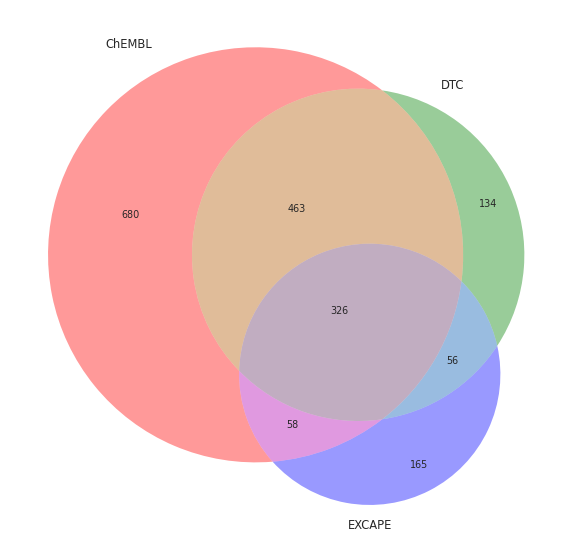

In [ ]:
mpv.venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

That's more like it. For even further overlaps, it's possible to pass all of them through the pubchem ID exchange: use input as smiles and output as smiles, then create base_rdkit_smiles again. You should see some increase in overlap with this pre-processing step.

## EDA: Examine compound diversity

In [ ]:
chembl=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_SMILES.csv", index_col=0)
dtc=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_SMILES.csv", index_col=0)
excape=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape_SMILES.csv", index_col=0)

In [ ]:
import diversity_plots as dp
sns.set_context('poster')

2021-03-05 18:21:19,030 Starting distance matrix calculation for 1949 compounds
2021-03-05 18:21:20,893 Finished calculation of 1898326 distances


array([0.93548387, 0.86206897, 0.98076923, ..., 0.88235294, 0.84810127,
       0.9047619 ])

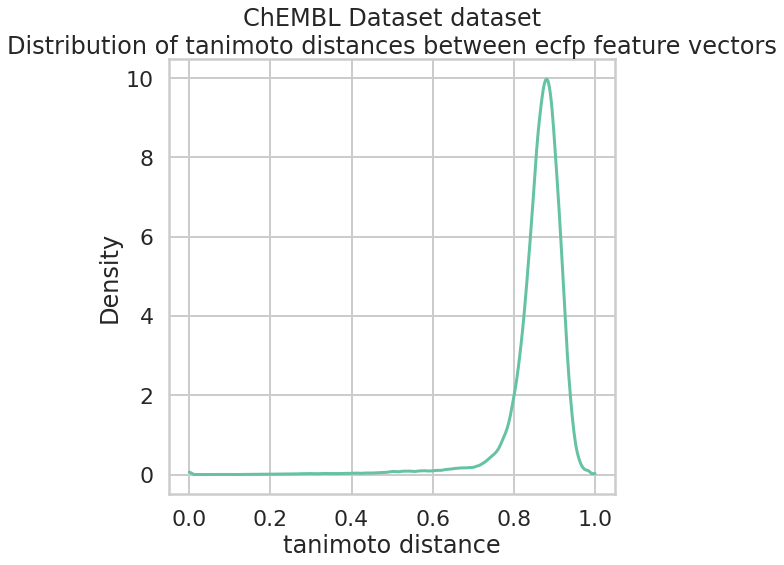

In [ ]:
dp.plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


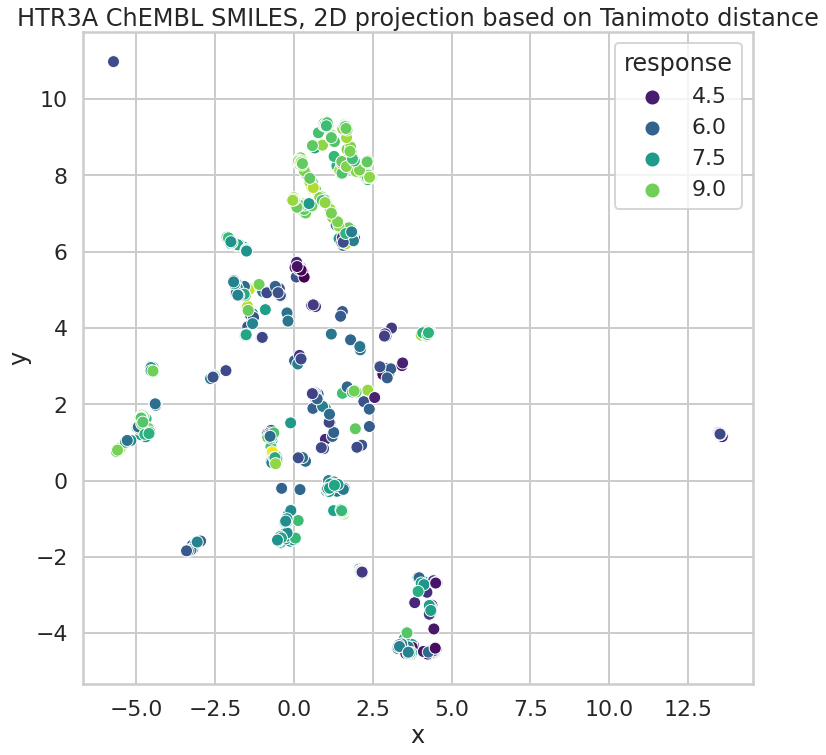

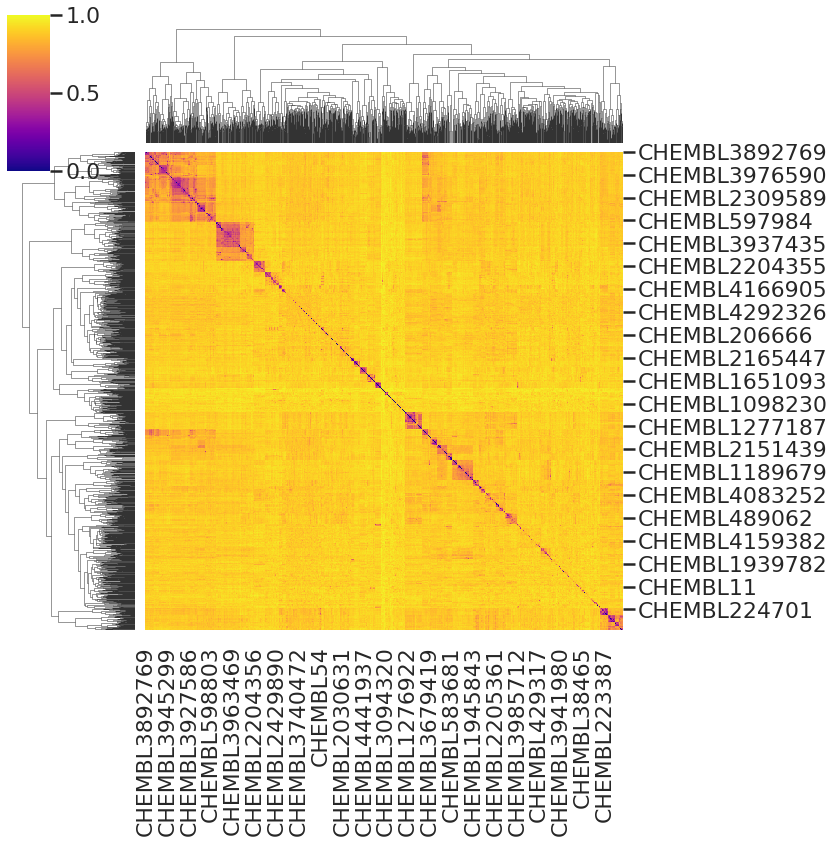

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_SMILES.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

#### ..

2021-03-05 18:21:43,523 Starting distance matrix calculation for 1277 compounds
2021-03-05 18:21:44,604 Finished calculation of 814726 distances


array([0.7761194 , 0.84536082, 0.89473684, ..., 0.96428571, 0.        ,
       0.        ])

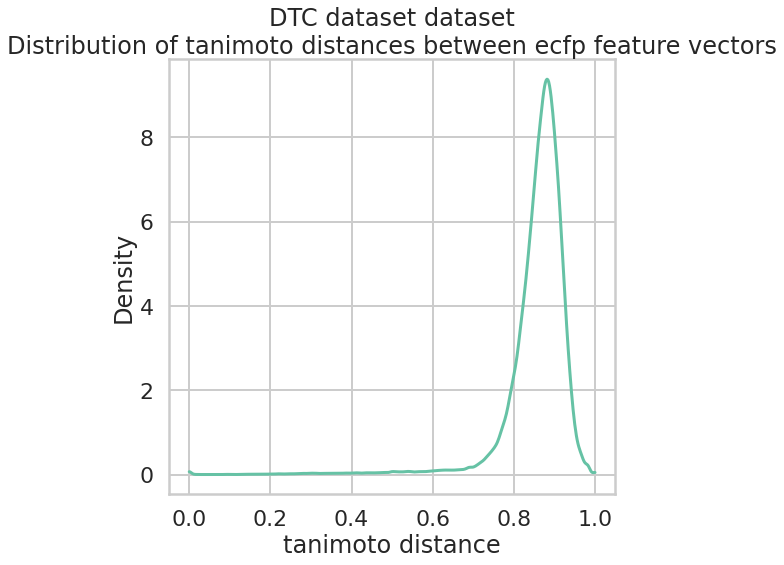

In [ ]:
dp.plot_tani_dist_distr(dtc, 'base_rdkit_smiles', 'DTC dataset')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


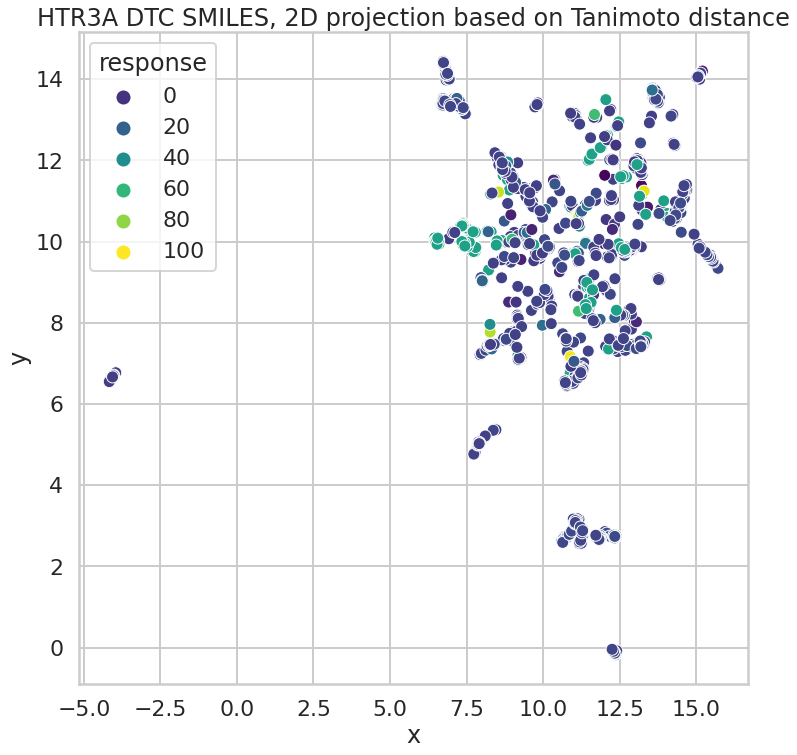

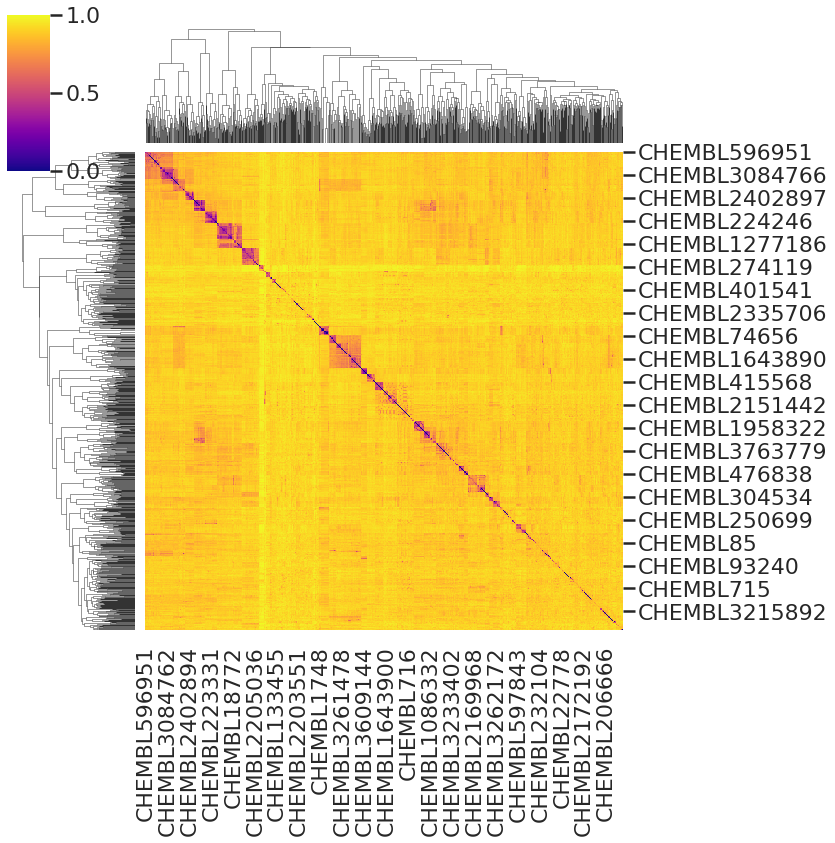

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_SMILES.csv', 
                   id_col ='Compound_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pDTC_Value')

2021-03-05 18:21:56,988 Starting distance matrix calculation for 649 compounds
2021-03-05 18:21:57,473 Finished calculation of 210276 distances


array([0.86842105, 0.90789474, 0.40983607, ..., 0.22058824, 0.77777778,
       0.77777778])

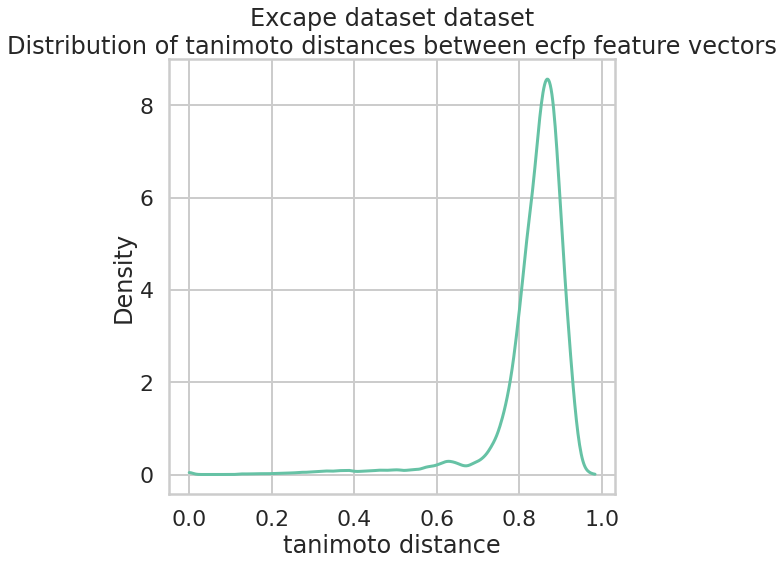

In [ ]:
dp.plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'Excape dataset')

In [ ]:
excape.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


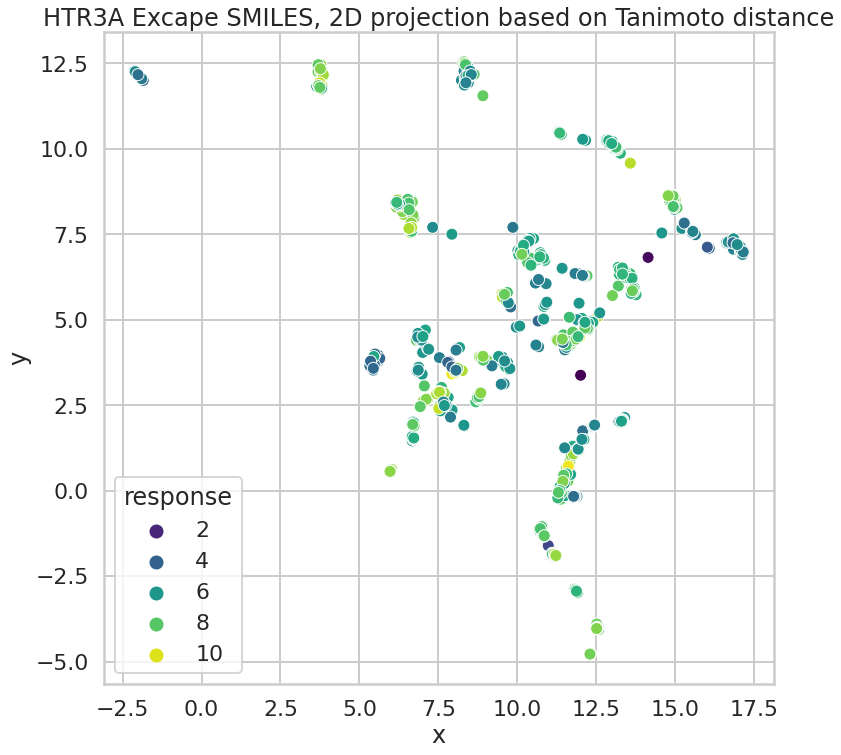

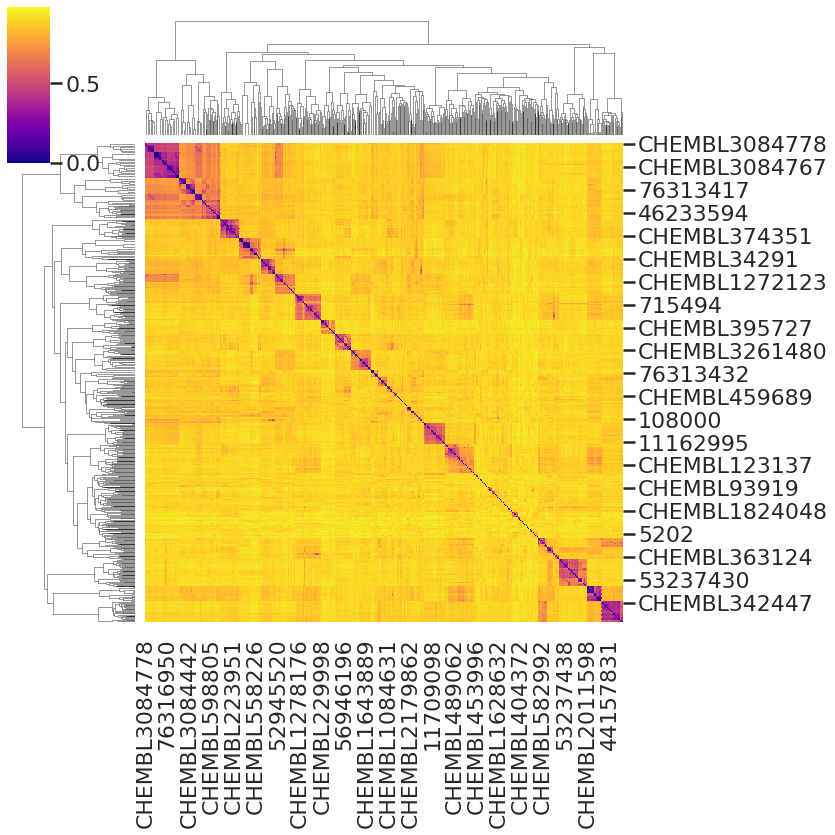

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape_SMILES.csv', 
                   id_col ='Original_Entry_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50')

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?

#### ..

- ECFP fingerprints are a bit vector representation of a compound's structure. Each bit represents the presence or absence of a certain 'connectivity' between atoms in a molecule. The radius used in the diversity plots function is radius 4 and length 1024. The tanimoto plot function uses radius 2. Radius means number of atoms you travel away from the given atom to assess connectivity, allowing you to look at larger or smaller molecule fragments.
- tanimoto similarity (or jaccard index) represents how well two bit vectors overlap. Thus, distance represents how 'far' away they are from perfect overlap. A distance closer 1 means the fingerprints (and therefore molecules) are less similar to each other. A distance closer to zero means molecules are more similar. 
- My compounds have average tanimoto distances ~ 0.85 - 0.9, so they are fairly diverse.
- In the ChEMBL dataset, the 2D project separates high and low pChEMBL values very well. The DTC and Excape datasets don't separate as well, but DTC also is on a very different scale.
- From the heatmap, I can see clusters/squares of compounds with tanimoto distance closer to zero (purple) so I suspect there are some groups of compounds that are very similar.

# EDA: Curated data
- First I will curate the data
- Examine new compound overlaps
- Examine final response column distributions
- Filter for 
  - large compounds
  - too high / too low pXC50 values
- double check for no NA values left
- save final curated dataset for further processing

In [ ]:
chembl=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_SMILES.csv", index_col=0)
dtc=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_SMILES.csv", index_col=0)
excape=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape_SMILES.csv", index_col=0)

In [ ]:
# rescue NA pChemblValues
chembl['pChEMBL_Value_nM'] = -np.log10(chembl.Standard_Value_nM/1000000000)
chembl.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
0      CHEMBL3233676           NaN                 0.0            622.85   
1          CHEMBL773       GLYCINE                 4.0             75.07   
2      CHEMBL3261486           NaN                 0.0            312.37   
3      CHEMBL3943065           NaN                 0.0            401.47   
4      CHEMBL2086584           NaN                 0.0            427.55   

   #RO5_Violations  AlogP Compound_Key  \
0              2.0   6.84          22a   
1              0.0  -0.97      glycine   
2              0.0   0.88            9   
3              0.0   2.21   BDBM221658   
4              0.0   2.99           27   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   
3   CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2          IC50   
4  COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   
3               '='            1.81             nM           8.74   
4               '>'        30000.00             nM            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   
3                   NaN          388070  UO_0000065                  21.78   
4                   NaN             NaN  UO_0000065                    NaN   

   Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                  0.43                   6.53                   12.1   
4                   NaN                    NaN                    NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   
3                False   CHEMBL3888296   
4                False   CHEMBL2091623   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   
3  In Vitro Inhibition of Ca Flux Assay: The 5HT3...          B   BAO_0000219   
4  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                    NaN               NaN   
1  cell-based format   Homo sapiens                    NaN               NaN   
2  cell-based format   Homo sapiens                    NaN               NaN   
3  cell-based format   Homo sapiens                    NaN               NaN   
4  cell-based format   Homo sapiens                    NaN               NaN   

  Assay_Cell_Type  Assay_Subcellular_Fraction Assay_Parameters  \
0             NaN                         NaN              NaN   
1          HEK293                         NaN              NaN   
2          HEK293                         NaN              NaN   
3        HEK-293T                         NaN              NaN 

In [ ]:
chembl.Standard_Type.unique()

array(['Inhibition', 'EC50', 'Activity', 'IC50', 'Ki', 'Vmax',
       '% Inhibition of Control Specific Binding (Mean n=2)', 'Ka',
       'pIC50', 'Emax', 'Kd', 'pKi', 'Kb', 'Selectivity ratio',
       'Efficacy', '% Ctrl'], dtype=object)

In [ ]:
# select pIC50 values
vals = ['EC50', 'IC50', 'pIC50']
print(chembl.shape)
chembl=chembl[chembl.Standard_Type.isin(vals)]
print(chembl.shape)

(1949, 48)
(602, 48)


In [ ]:
# drop NA pIC50's & smiles
chembl=chembl.dropna(axis=0, subset = ['pChEMBL_Value_nM','base_rdkit_smiles'])
print(chembl.shape)

(594, 48)


In [ ]:
# note weird punctuation
chembl.Standard_Relation.unique()

array(["'='", "'>'", "'<'"], dtype=object)

In [ ]:
# flip arrows and fix punctuation for relation column to reflect pValues not normal values
chembl['pRelation'] = chembl.Standard_Relation
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'<'", ">", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'>'", "<", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'='", "=", chembl.pRelation)
chembl[['Standard_Relation', 'pRelation']].head()

Standard_Relation pRelation
3               '='         =
4               '>'         <
5               '='         =
6               '>'         <
7               '>'         <

In [ ]:
thresh=-np.log10(100/1000000000) # pIC50 of 100nM for threshold

In [ ]:
print(chembl.shape)
chembl_cur = curate_data.aggregate_assay_data(chembl, value_col = 'pChEMBL_Value_nM', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Molecule_ChEMBL_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
print(chembl_cur.shape)
chembl_cur.head()

(594, 49)
0 entries in input table are missing SMILES strings
517 unique SMILES strings are reduced to 517 unique base SMILES strings
(517, 5)


compound_id                                  base_rdkit_smiles relation  \
0    CHEMBL11608                                     NCCc1ccc(O)cc1            
1  CHEMBL3941887        CN1C2COCC1CC(NC(=O)c1nn(CC(F)F)c3ccccc13)C2            
2  CHEMBL3896879        CN1C2CCCC1CC(NC(=O)c1cn(CC(F)F)c3ncccc13)C2            
3   CHEMBL223951  O=C(NCCN1CCCCC1)c1ccc2c(=O)n(Cc3ccccc3Cl)c(=O)...            
4   CHEMBL267615                      CCc1[nH]c2ccc(OC)cc2c1CCN(C)C        <   

      pXC50  active  
0  4.585027       0  
1  9.397940       1  
2  7.978811       1  
3  5.677781       0  
4  6.000000       0

In [ ]:
chembl_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_cur.csv")

In [ ]:
# DTC
# select pIC50 values
vals = ['EC50', 'IC50', 'PIC50']
print(dtc.shape)
dtc=dtc[dtc.End_Point_Standard_Type.isin(vals)]
print(dtc.shape)

# flip arrows for relation column to reflect pValues not normal values
dtc['pRelation'] = dtc.End_Point_Standard_Relation
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == "<", ">", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == ">", "<", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == "=", "=", dtc.pRelation)
print(dtc.pRelation.unique())
display(dtc[['End_Point_Standard_Relation', 'pRelation']].head())

dtc=dtc.dropna(axis=0, subset = ['pDTC_Value','base_rdkit_smiles'])
print(dtc.shape)

# aggregate duplicates
dtc_cur = curate_data.aggregate_assay_data(dtc, value_col = 'pDTC_Value', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Compound_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
dtc_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_cur.csv")
print(dtc_cur.shape)
print(dtc_cur.relation.unique())
dtc_cur.head()

(1277, 46)
(257, 46)
['<' '=' nan '>']


End_Point_Standard_Relation pRelation
0                           >         <
4                           >         <
5                           >         <
6                           >         <
7                           >         <

(249, 47)
0 entries in input table are missing SMILES strings
208 unique SMILES strings are reduced to 208 unique base SMILES strings
(208, 5)
['' '<' '>']


compound_id                                  base_rdkit_smiles relation  \
0    CHEMBL53929                                  NCC(O)c1ccc(O)cc1            
1  CHEMBL1083485            O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccccc2F)nc1        <   
2    CHEMBL11608                                     NCCc1ccc(O)cc1            
3  CHEMBL1277099  Nn1c(SCCCN2CCN(c3ccc4ccccc4n3)CC2)nc2sc3c(c2c1...            
4  CHEMBL1448856                     Fc1ccccc1CSc1ncnc2c1oc1ccccc12            

      pXC50  active  
0  7.619789       1  
1  4.522879       0  
2  4.585027       0  
3  7.383000       1  
4  4.000000       0

In [ ]:
# excape: has no relation col, so create one with all ''
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)
# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape, value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()

(649, 13)
['']
(645, 13)
0 entries in input table are missing SMILES strings
601 unique SMILES strings are reduced to 600 unique base SMILES strings
(600, 5)
['']


compound_id                                  base_rdkit_smiles relation  \
0  CHEMBL3084783  CN1[C@H]2CCC[C@@H]1C[C@@H](NC(=O)c1cccc3nc(-c4...            
1   CHEMBL295155          COc1cc(N)c(Cl)cc1C(=O)NC1C2CC3CC1CN(C3)C2            
2   CHEMBL223951  O=C(NCCN1CCCCC1)c1ccc2c(=O)n(Cc3ccccc3Cl)c(=O)...            
3   CHEMBL124886                  CN1CCN(c2nc3cccc(F)c3n3cccc23)CC1            
4   CHEMBL224160  CC1CCCCN1CCNC(=O)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c(...            

   pXC50  active  
0   7.39       1  
1   8.05       1  
2   5.68       0  
3   9.36       1  
4   5.55       0

In [ ]:
chembl_cur['datasource'] = 'chembl'
dtc_cur['datasource']='dtc'
excape_cur['datasource']='excape'
HTR3A = pd.concat([chembl_cur, dtc_cur, excape_cur])
HTR3A.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_merge.csv")
print(HTR3A.shape)

(1325, 6)


In [ ]:
import importlib
importlib.reload(curate_data)
HTR3A_cur = curate_data.aggregate_assay_data(HTR3A, value_col = 'pXC50', 
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'relation',
                                              active_thresh=thresh)

print(HTR3A_cur.shape)
print(HTR3A.relation.unique())
HTR3A_cur.head()

0 entries in input table are missing SMILES strings
1023 unique SMILES strings are reduced to 1023 unique base SMILES strings
(1023, 5)
['' '<' '>']


compound_id                                  base_rdkit_smiles relation  \
0    CHEMBL11608                                     NCCc1ccc(O)cc1            
1  CHEMBL3941887        CN1C2COCC1CC(NC(=O)c1nn(CC(F)F)c3ccccc13)C2            
2  CHEMBL3084783  CN1[C@H]2CCC[C@@H]1C[C@@H](NC(=O)c1cccc3nc(-c4...            
3  CHEMBL3896879        CN1C2CCCC1CC(NC(=O)c1cn(CC(F)F)c3ncccc13)C2            
4   CHEMBL295155          COc1cc(N)c(Cl)cc1C(=O)NC1C2CC3CC1CN(C3)C2            

      pXC50  active  
0  4.585027       0  
1  9.397940       1  
2  7.390000       1  
3  7.978811       1  
4  8.050000       1

In [ ]:
HTR3A_cur.relation.unique()

array(['', '<'], dtype=object)

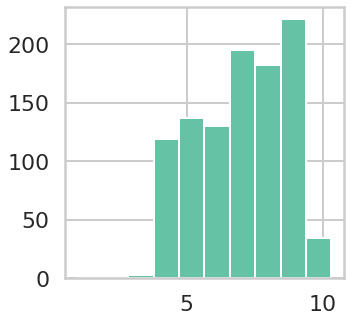

In [ ]:
HTR3A_cur.pXC50.hist(figsize=(5,5));

In [ ]:
HTR3A_cur.active.sum()

552

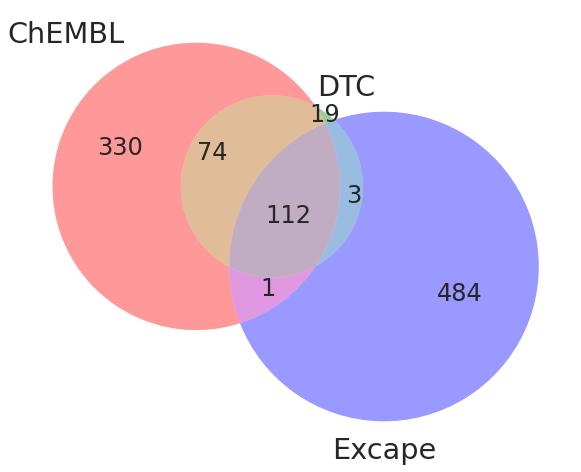

In [ ]:
mpv.venn3([set(HTR3A.loc[HTR3A.datasource=='chembl','base_rdkit_smiles']),
           set(HTR3A.loc[HTR3A.datasource=='dtc','base_rdkit_smiles']),
           set(HTR3A.loc[HTR3A.datasource=='excape','base_rdkit_smiles']),],
          set_labels = ['ChEMBL','DTC','Excape']);

2021-03-05 18:22:15,608 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


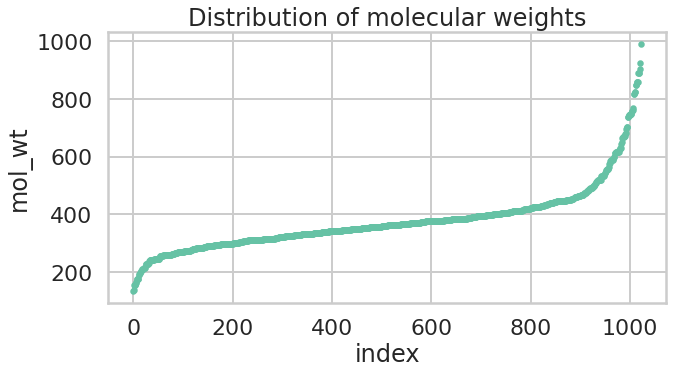

In [ ]:
HTR3A_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in HTR3A_cur["base_rdkit_smiles"]]
HTR3A_cur = HTR3A_cur.sort_values('mol_wt')
HTR3A_cur=HTR3A_cur.reset_index(drop=True)
HTR3A_cur=HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(10,5))
HTR3A_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [ ]:
print(HTR3A_cur.shape)
HTR3A_cur = HTR3A_cur[HTR3A_cur.mol_wt <1400]
print(HTR3A_cur.shape)

(1023, 7)
(1023, 7)


2021-03-05 18:22:15,952 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


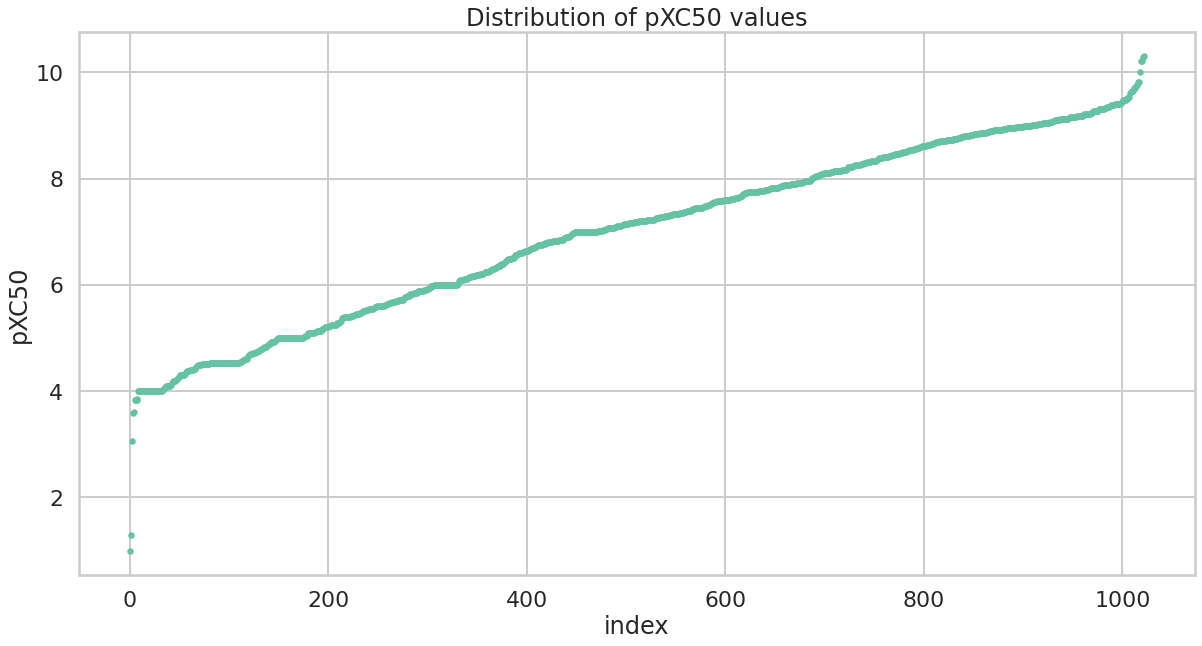

In [ ]:
HTR3A_cur=HTR3A_cur.drop(columns=['index'])
HTR3A_cur = HTR3A_cur.sort_values('pXC50')
HTR3A_cur = HTR3A_cur.reset_index(drop=True)
HTR3A_cur = HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HTR3A_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [ ]:
print(HTR3A_cur.shape)
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50>2]
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50<14]
print(HTR3A_cur.shape)

(1023, 7)
(1021, 7)


In [ ]:
for col in HTR3A_cur.columns:
  print(col, HTR3A_cur[col].isna().values.any())

index False
compound_id False
base_rdkit_smiles False
relation False
pXC50 False
active False
mol_wt False


2021-03-05 18:22:16,363 Starting distance matrix calculation for 1021 compounds
2021-03-05 18:22:17,055 Finished calculation of 520710 distances


array([0.94444444, 0.88888889, 0.94642857, ..., 0.83950617, 0.83950617,
       0.85294118])

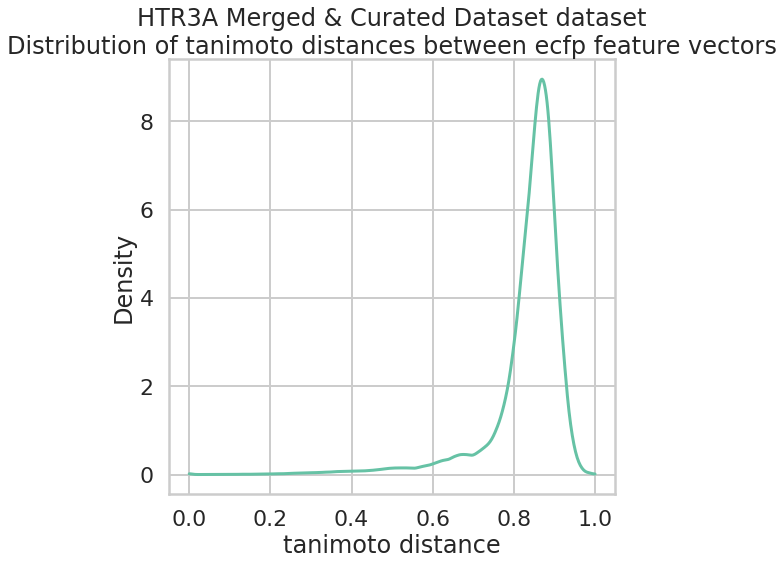

In [ ]:
dp.plot_tani_dist_distr(HTR3A_cur, 'base_rdkit_smiles', 'HTR3A Merged & Curated Dataset')

In [ ]:
HTR3A_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv")

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


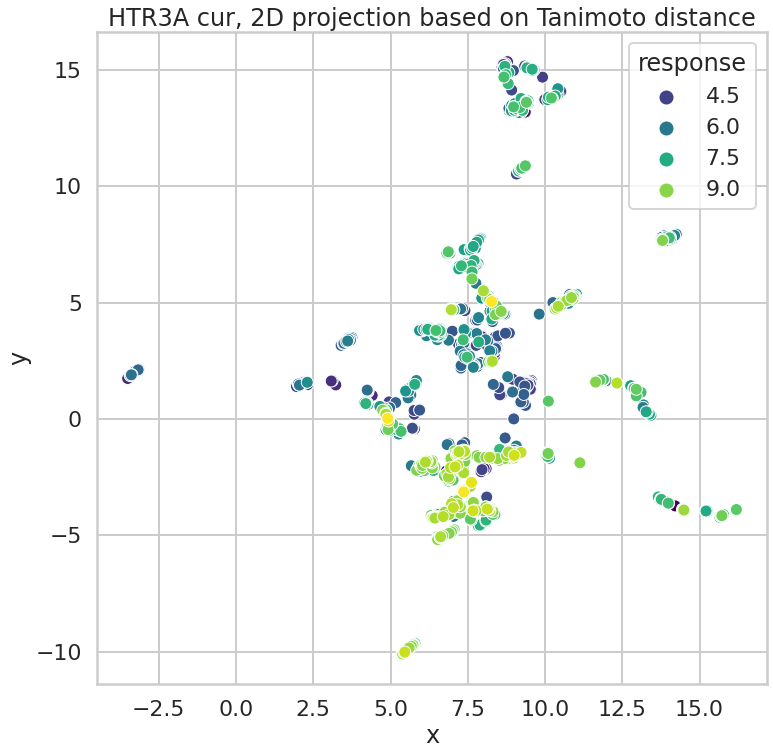

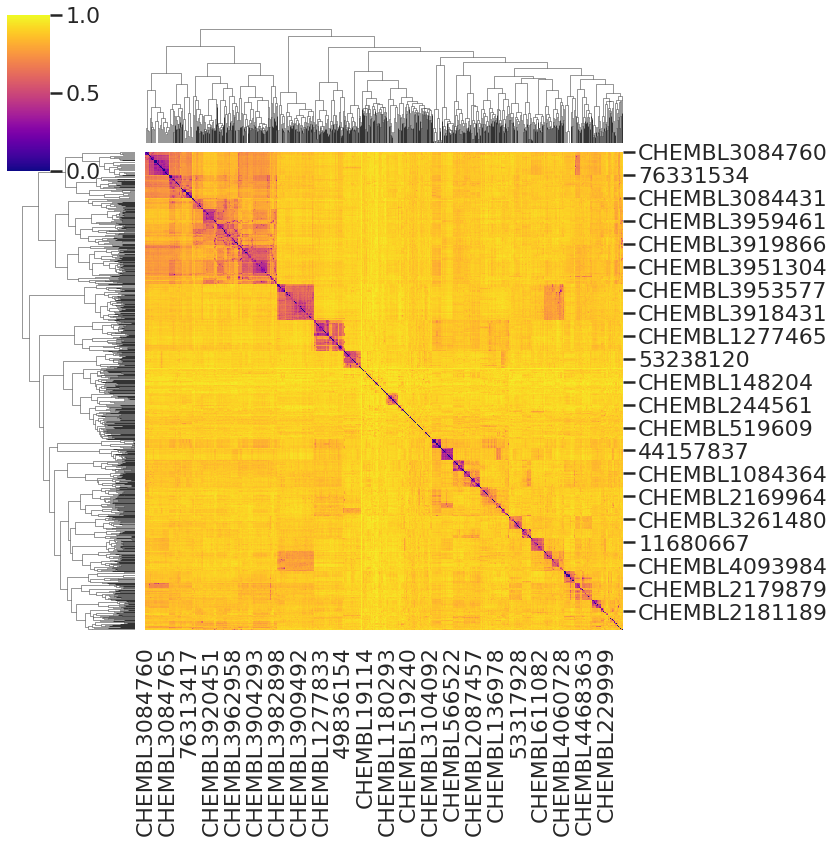

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


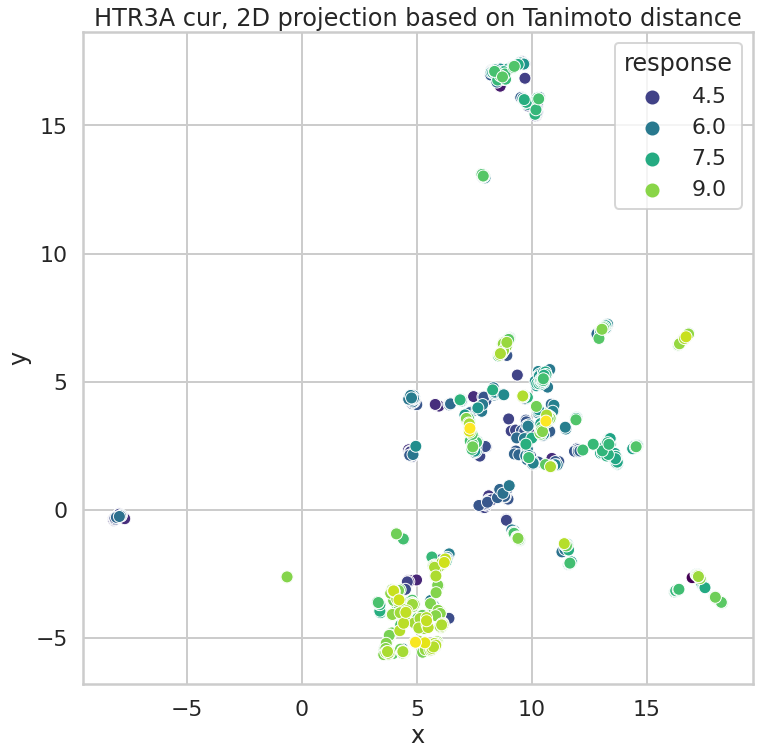

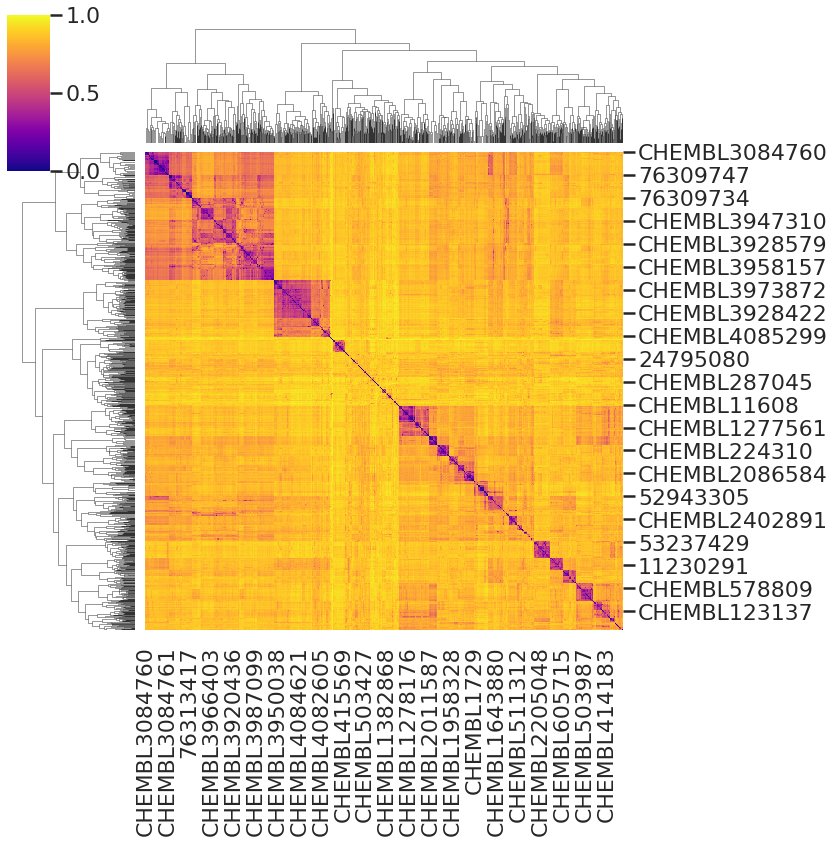

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50',
                   ecfp_radius = 2)

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


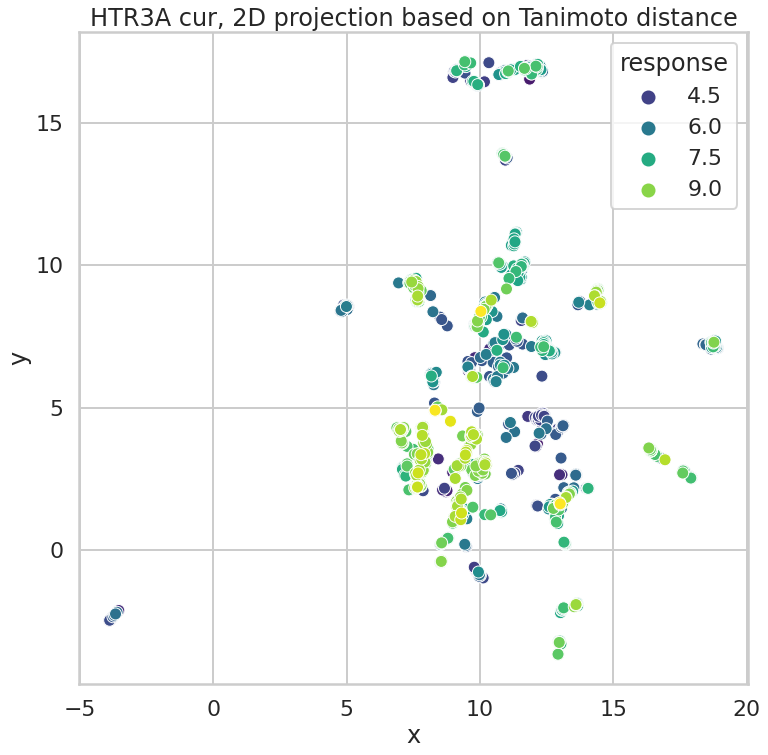

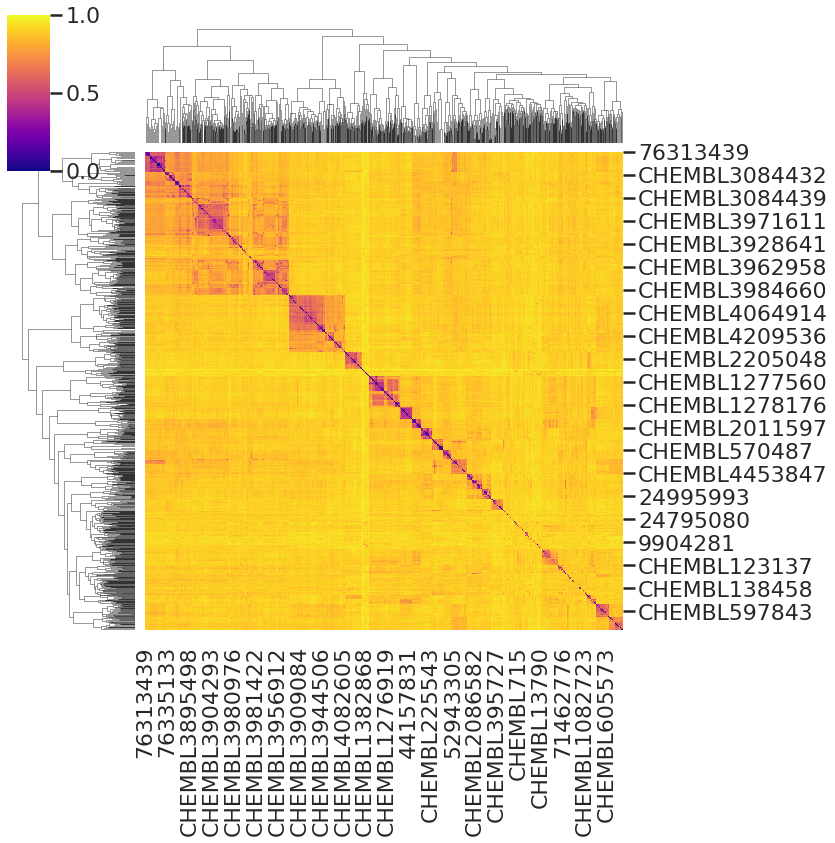

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50',
                   ecfp_radius = 6)

In [ ]:
# warning: 1000 doesn't work, takes too long
importlib.reload(dp)
# dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50', 
#                    max_for_mcs=1100)

<module 'diversity_plots' from '/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py'>

# Now you're ready to move on to the next stage of EDA & modeling: featurizing datasets
- featurize with structure-based fingerprints like ECFP
- or molecular descriptor sets like RDKit and Mordred
- these are high - dimensional datasets (200-2000 features or 'dimensions')
- so UMAP, tSNE and other dimensionality reduction techniques will help visualize the 'chemical space' of the dataset